In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#### Seeds Random para Tensorflow y Numpy

In [ ]:
tf.random.set_seed(123)
np.random.seed(123)

#### Dataset de Consumo

In [ ]:
df_consumo = pd.read_csv('./df_consumo.csv', index_col='Fecha', parse_dates=True)

#### Normalización de los datos | Primer Modelo: Diesel (Consumo)

In [ ]:
ts = df_consumo['Diesel'].astype(float)          # barriles
ts_log = np.log(ts)
ts_log_diff = ts_log.diff().dropna()             # d=1

#### Serie de tiempo de Diesel (Consumo)

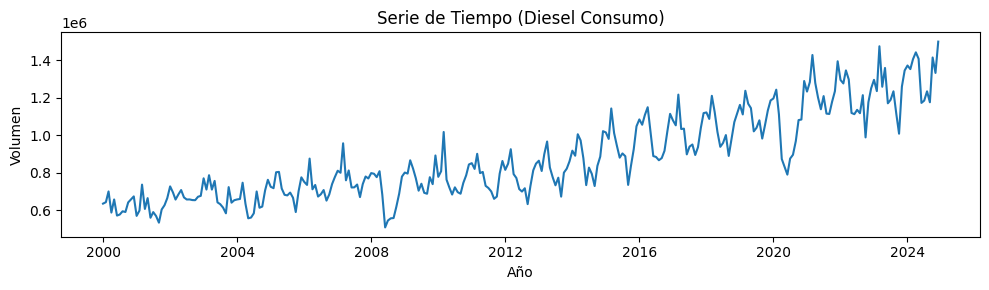

In [63]:
plt.figure(figsize=(10,3))
plt.plot(ts)
plt.title("Serie de Tiempo (Diesel Consumo)")
plt.xlabel("Año"); plt.ylabel("Volumen")
plt.tight_layout(); plt.show()


#### Vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media

In [ ]:
mediaMovil = ts.rolling(window=12).mean()
deMovil    = ts.rolling(window=12).std()

plt.figure(figsize=(10,3))
plt.plot(ts, label="Original", color="blue")
plt.plot(mediaMovil, label="Media móvil (12)", color="red")
plt.plot(deMovil, label="Desv. estándar móvil (12)", color="black")
plt.legend(loc='best')
plt.title("Media y desviación estándar móvil (12 meses)")
plt.tight_layout(); plt.show()

#### Descomposición Aditiva

In [ ]:
descomp = seasonal_decompose(ts, model='additive')
descomp.plot()
plt.suptitle("Descomposición aditiva", y=1.02)
plt.tight_layout(); plt.show()

#### Prueba Dickey-Fuller Media

In [ ]:
print("Resultados del Test de Dickey-Fuller (ADF)")
res = adfuller(ts.dropna(), autolag='AIC')
salida = pd.Series(res[0:4],
                   index=['Estadístico de prueba','p-value',
                          '# retardos usados','# observaciones'])
for k,v in res[4].items():
    salida[f'Critical Value ({k})'] = v
print(salida)

if salida['p-value'] < 0.05:
    print("→ Con p-value < 0.05: rechazamos H0. La serie es ESTACIONARIA en media.")
else:
    print("→ Con p-value ≥ 0.05: NO rechazamos H0. La serie NO es estacionaria en media.")

#### ¿Estacionalidad en Varianza?

In [ ]:
win = 36  # meses
var_ini = ts.iloc[:win].var()
var_fin = ts.iloc[-win:].var()

ratio = abs(var_fin - var_ini) / var_ini
print(f"\nVarianza inicial: {var_ini:,.2f} | Varianza final: {var_fin:,.2f} | Cambio relativo: {ratio:.2%}")

if ratio < 0.20:
    print("→ La varianza parece aproximadamente constante (estacionaria en varianza).")
else:
    print("→ La varianza cambia de forma importante. No es estacionaria en varianza.")

#### Función para supervisar

In [ ]:
def to_supervised(series, lookback=12):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

def invert_log_diff(base_logs, diffs):
    """base_logs y diffs deben tener mismo largo.
       base_logs: log(y_{t-1}), diffs: Δlog(y_t)=log(y_t)-log(y_{t-1})"""
    vals = np.exp(base_logs + diffs.reshape(-1))
    return vals

#### Split en train / val / test

In [ ]:
lookback = 12
X_all, y_all = to_supervised(ts_log_diff.values.reshape(-1,1), lookback)

n = len(X_all)
n_train = int(n*0.7)
n_val   = int(n*0.15)

X_train, y_train = X_all[:n_train], y_all[:n_train]
X_val,   y_val   = X_all[n_train:n_train+n_val], y_all[n_train:n_train+n_val]
X_test,  y_test  = X_all[n_train+n_val:], y_all[n_train+n_val:]

#### Scaling y Reshape

In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()

X_train_2d = X_train.reshape(X_train.shape[0], -1)   # (samples, lookback*features)
X_val_2d   = X_val.reshape(X_val.shape[0], -1)
X_test_2d  = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = sc_X.fit_transform(X_train_2d)
X_val_scaled   = sc_X.transform(X_val_2d)
X_test_scaled  = sc_X.transform(X_test_2d)

y_train_scaled = sc_y.fit_transform(y_train)
y_val_scaled   = sc_y.transform(y_val)
y_test_scaled  = sc_y.transform(y_test)

# Reshape back to (samples, timesteps, features=1)
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], lookback, 1)
X_val_scaled   = X_val_scaled.reshape(X_val.shape[0], lookback, 1)
X_test_scaled  = X_test_scaled.reshape(X_test.shape[0], lookback, 1)

#### Modelos LSTM

##### Modelo #1

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(lookback,1)),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[es],
    verbose=1
)

##### Modelo #2

In [ ]:
model1 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    LSTM(32),
    Dense(1)
])
model1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

es1 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history1 = model1.fit(
    X_train_scaled, y_train_scaled,
    epochs=300,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[es],
    verbose=1
)

#### Curvas de pérdida

##### Modelo #1

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss (MSE)')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

##### Modelo #2

In [ ]:
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='val')
plt.title('Loss (MSE)')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

#### Evaluación de los modelos

##### Modelo #1

In [ ]:
print("Pérdida en Entrenamiento (Modelo 1)")
model.evaluate(
    x = X_train_scaled,
    y = y_train
)
print("Pérdida en Validación (Modelo 1)")
model.evaluate(
    x = X_val_scaled,
    y = y_val
)
print("Pérdida en Prueba (Modelo 1)")
model.evaluate(
    x = X_test_scaled,
    y = y_test
)

##### Modelo #2

In [ ]:
print("Pérdida en Entrenamiento (Modelo 2)")
model1.evaluate(
    x = X_train_scaled,
    y = y_train
)
print("Pérdida en Validación (Modelo 2)")
model1.evaluate(
    x = X_val_scaled,
    y = y_val
)
print("Pérdida en Prueba (Modelo 2)")
model1.evaluate(
    x = X_test_scaled,
    y = y_test
)

#### Setup de predicción

In [ ]:
def predict_level(modelo, X_scaled, start_idx):
    """start_idx: posición en ts_log del primer target de este bloque"""
    # 1. predicción en escala y_diff
    yhat_scaled = modelo.predict(X_scaled, verbose=0)
    yhat_diff = sc_y.inverse_transform(yhat_scaled)  # Δlog

    # 2. base log (log del último valor de cada ventana)
    #   Para el primer elemento del bloque, el último log está en ts_log[start_idx-1]
    base_logs = []
    for i in range(len(yhat_diff)):
        base_logs.append(ts_log.iloc[start_idx - 1 + i])
    base_logs = np.array(base_logs)

    # 3. revertir diferencia + log
    yhat_level = invert_log_diff(base_logs, yhat_diff)
    return yhat_level

##### Modelo #1 y #2

In [ ]:
start_val  = lookback + n_train
start_test = lookback + n_train + n_val

y_val_pred_m1  = predict_level(model,  X_val_scaled,  start_val)
y_test_pred_m1 = predict_level(model,  X_test_scaled, start_test)

y_val_pred_m2  = predict_level(model1, X_val_scaled,  start_val)
y_test_pred_m2 = predict_level(model1, X_test_scaled, start_test)

# Truth (nivel original) para val/test
y_val_true  = ts.iloc[start_val : start_val + len(y_val_pred_m1)].values
y_test_true = ts.iloc[start_test: start_test + len(y_test_pred_m1)].values

#### Métricas y Gráficas de Validación / Predicción

In [58]:
def metrics(y_true, y_pred, name):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f'{name} → RMSE: {rmse:,.0f}  |  MAE: {mae:,.0f} barriles')

##### Modelo #1

In [59]:
metrics(y_val_true,  y_val_pred_m1,  "Val M1")
metrics(y_test_true, y_test_pred_m1, "Test M1")


Val M1 → RMSE: 117,229  |  MAE: 86,733 barriles
Test M1 → RMSE: 159,016  |  MAE: 126,121 barriles


##### Modelo #2

In [60]:
metrics(y_val_true,  y_val_pred_m2,  "Val M2")
metrics(y_test_true, y_test_pred_m2, "Test M2")

Val M2 → RMSE: 96,665  |  MAE: 69,925 barriles
Test M2 → RMSE: 117,955  |  MAE: 91,778 barriles


##### Gráfica Modelo 1

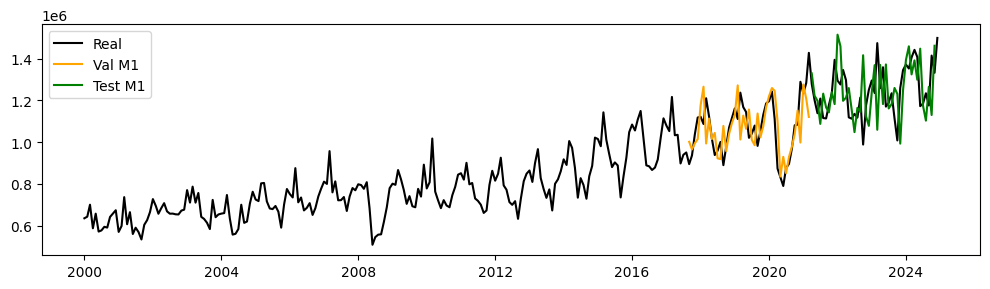

In [61]:
idx_val  = ts.index[start_val : start_val + len(y_val_pred_m1)]
idx_test = ts.index[start_test: start_test + len(y_test_pred_m1)]

plt.figure(figsize=(10,3))
plt.plot(ts, color='black', label='Real')
plt.plot(idx_val,  y_val_pred_m1,  'orange', label='Val M1')
plt.plot(idx_test, y_test_pred_m1, 'green',  label='Test M1')
plt.legend(); plt.tight_layout(); plt.show()

##### Gráfica Modelo #2

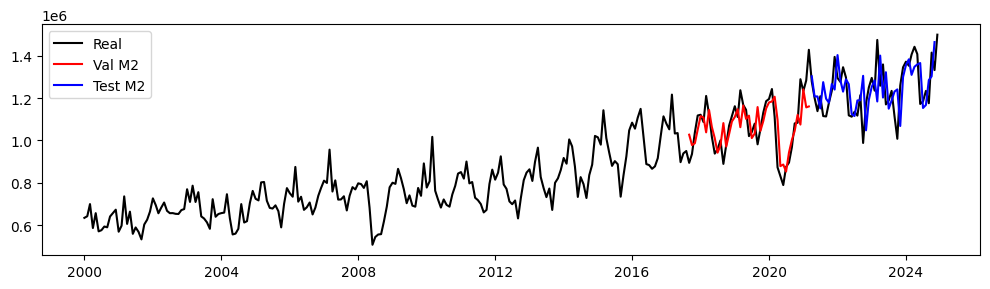

In [62]:
plt.figure(figsize=(10,3))
plt.plot(ts, color='black', label='Real')
plt.plot(idx_val,  y_val_pred_m2,  'red', label='Val M2')
plt.plot(idx_test, y_test_pred_m2, 'blue', label='Test M2')
plt.legend(); plt.tight_layout(); plt.show()